# Amazon RecSys GNN - Final Combined Notebook

이 노트북은 Amazon RecSys 프로젝트의 **전처리, 모델 학습, 평가, 결과 생성** 과정을 모두 포함한 최종 버전입니다.

## 주요 내용
1. **데이터 분석 및 전처리**: 데이터 로드, 기초 통계, User/Item 매핑, Train/Val/Test Split.
2. **모델 구현**: LightGCN (Graph Neural Network) 모델 및 BPR Loss 구현.
3. **모델 학습**: CPU를 활용한 모델 학습 (MPS Sparse Tensor 호환성 문제 해결).
4. **평가 및 결과 생성**: 새로운 평가 규칙(50% 제한, 10개 이하 유저 2개 추천)을 적용한 추천 및 O/X 결과 생성.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
import scipy.sparse as sp
import os
from sklearn.model_selection import train_test_split

# 시드 고정
def seed_everything(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything(42)

# 디바이스 설정
# MPS(Mac GPU)는 Sparse Tensor 연산(aten::addmm)을 완벽하게 지원하지 않아 오류가 발생할 수 있습니다.
# 안정적인 학습을 위해 CPU를 사용합니다.
device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cpu


## 1. 데이터 로드 및 전처리

In [2]:
# 데이터 로드
print('Loading data...')
df = pd.read_csv('../data/amazon_train.csv')

# 데이터 확인
print(f'Total Interactions: {len(df)}')
print(f'Unique Users: {df["user"].nunique()}')
print(f'Unique Items: {df["item"].nunique()}')

# User/Item ID Mapping
user_mapper = {u: i for i, u in enumerate(df['user'].unique())}
item_mapper = {i: j for j, i in enumerate(df['item'].unique())}

df['user_idx'] = df['user'].map(user_mapper)
df['item_idx'] = df['item'].map(item_mapper)

n_users = len(user_mapper)
n_items = len(item_mapper)

# Train/Val/Test Split Strategy
# 1. Interaction < 2: Train Only (Cold Start 방지)
# 2. Interaction >= 2: Train/Val/Test 분할 (Test 15%, Val 15%, Train 70% 목표)

print('Splitting data into Train/Val/Test...')
train_list = []
val_list = []
test_list = []

grouped = df.groupby('user_idx')

for user_idx, group in tqdm(grouped, desc='Splitting Users'):
    n = len(group)
    if n < 2:
        train_list.append(group)
    else:
        # Test Split (Ensure at least 1)
        test_size = max(1, int(n * 0.15))
        tr_val, te = train_test_split(group, test_size=test_size, random_state=42)
        test_list.append(te)
        
        # Val Split (Ensure at least 1 if possible, keep at least 1 in Train)
        rem = len(tr_val)
        if rem > 1:
            val_size = max(1, int(n * 0.15))
            if val_size >= rem: val_size = rem - 1
            tr, va = train_test_split(tr_val, test_size=val_size, random_state=42)
            train_list.append(tr)
            val_list.append(va)
        else:
            train_list.append(tr_val)

train_df = pd.concat(train_list)
val_df = pd.concat(val_list)
test_df = pd.concat(test_list)

print(f'Train Size: {len(train_df)}')
print(f'Val Size: {len(val_df)}')
print(f'Test Size: {len(test_df)}')

Loading data...
Total Interactions: 568263
Unique Users: 256009
Unique Items: 74233
Splitting data into Train/Val/Test...


Splitting Users: 100%|██████████| 256009/256009 [01:01<00:00, 4154.51it/s] 


Train Size: 420533
Val Size: 57540
Test Size: 90190


## 2. 모델 정의 (LightGCN)

In [3]:
# Adjacency Matrix 생성 (Sparse Tensor)
def create_adj_matrix(df, n_users, n_items):
    u = df['user_idx'].values
    i = df['item_idx'].values
    
    user_np = np.array(u)
    item_np = np.array(i)
    
    ratings = np.ones_like(user_np, dtype=np.float32)
    
    n_nodes = n_users + n_items
    
    # Direct COO Construction
    tmp_adj = sp.coo_matrix((ratings, (user_np, item_np + n_users)), shape=(n_nodes, n_nodes))
    adj_mat = tmp_adj + tmp_adj.T
    
    # Normalize
    rowsum = np.array(adj_mat.sum(axis=1))
    d_inv = np.power(rowsum, -0.5).flatten()
    d_inv[np.isinf(d_inv)] = 0.
    d_mat = sp.diags(d_inv)
    
    norm_adj = d_mat.dot(adj_mat).dot(d_mat)
    norm_adj = norm_adj.tocoo()
    
    indices = torch.from_numpy(np.vstack((norm_adj.row, norm_adj.col)).astype(np.int64))
    values = torch.from_numpy(norm_adj.data.astype(np.float32))
    shape = torch.Size(norm_adj.shape)
    
    return torch.sparse_coo_tensor(indices, values, shape)

print('Creating Adjacency Matrix...')
adj_matrix = create_adj_matrix(train_df, n_users, n_items)
adj_matrix = adj_matrix.to(device)
print('Adjacency Matrix created.')

Creating Adjacency Matrix...
Adjacency Matrix created.


/var/folders/mh/1w84fr7s5kxcwc2l24qrjjwc0000gn/T/ipykernel_82529/3294075847.py:19: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(rowsum, -0.5).flatten()


In [4]:
# LightGCN 모델
class LightGCN(nn.Module):
    def __init__(self, n_users, n_items, emb_dim=64, n_layers=3):
        super(LightGCN, self).__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        
        self.user_embedding = nn.Embedding(n_users, emb_dim)
        self.item_embedding = nn.Embedding(n_items, emb_dim)
        
        nn.init.normal_(self.user_embedding.weight, std=0.1)
        nn.init.normal_(self.item_embedding.weight, std=0.1)
        
    def forward(self, adj_matrix):
        all_emb = torch.cat([self.user_embedding.weight, self.item_embedding.weight])
        embs = [all_emb]
        
        for layer in range(self.n_layers):
            all_emb = torch.sparse.mm(adj_matrix, all_emb)
            embs.append(all_emb)
            
        embs = torch.stack(embs, dim=1)
        final_emb = torch.mean(embs, dim=1)
        
        users_emb, items_emb = torch.split(final_emb, [self.n_users, self.n_items])
        return users_emb, items_emb

# BPR Loss
class BPRLoss(nn.Module):
    def __init__(self, decay=1e-4):
        super(BPRLoss, self).__init__()
        self.decay = decay
        
    def forward(self, users_emb, items_emb, users, pos_items, neg_items, current_user_emb, current_pos_item_emb, current_neg_item_emb):
        u_emb = users_emb[users]
        pos_emb = items_emb[pos_items]
        neg_emb = items_emb[neg_items]
        
        pos_scores = torch.sum(u_emb * pos_emb, dim=1)
        neg_scores = torch.sum(u_emb * neg_emb, dim=1)
        
        loss = -torch.mean(torch.nn.functional.logsigmoid(pos_scores - neg_scores))
        
        reg_loss = (1/2) * (current_user_emb.norm(2).pow(2) + 
                            current_pos_item_emb.norm(2).pow(2) + 
                            current_neg_item_emb.norm(2).pow(2)) / float(len(users))
        
        return loss + self.decay * reg_loss

In [5]:
# Dataset
class TrainDataset(Dataset):
    def __init__(self, df, n_items):
        self.users = df['user_idx'].values
        self.items = df['item_idx'].values
        self.n_items = n_items
        
    def __len__(self):
        return len(self.users)
    
    def __getitem__(self, idx):
        user = self.users[idx]
        pos_item = self.items[idx]
        
        while True:
            neg_item = np.random.randint(0, self.n_items)
            if neg_item != pos_item:
                break
                
        return user, pos_item, neg_item

## 3. 모델 학습

Initializing Model...
Starting Training...


Epoch 1/5: 100%|██████████| 206/206 [01:02<00:00,  3.28it/s]


Epoch 1 Loss: 0.5963


Epoch 2/5: 100%|██████████| 206/206 [00:53<00:00,  3.87it/s]


Epoch 2 Loss: 0.4045


Epoch 3/5: 100%|██████████| 206/206 [00:59<00:00,  3.44it/s]


Epoch 3 Loss: 0.2807


Epoch 4/5: 100%|██████████| 206/206 [01:01<00:00,  3.36it/s]


Epoch 4 Loss: 0.2036


Epoch 5/5: 100%|██████████| 206/206 [01:04<00:00,  3.22it/s]


Epoch 5 Loss: 0.1516


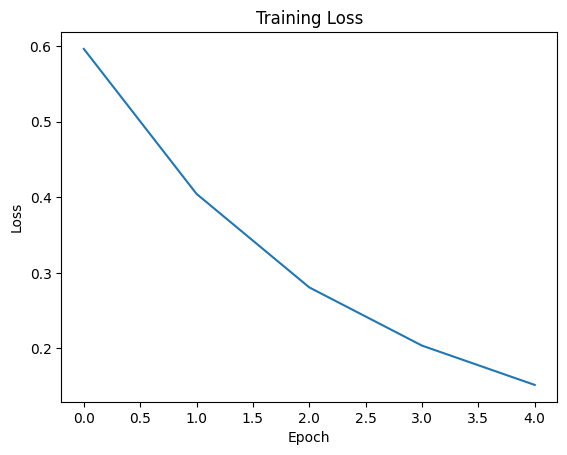

In [6]:
# Hyperparameters
EMB_DIM = 64
N_LAYERS = 2
BATCH_SIZE = 2048
LR = 0.001
EPOCHS = 5
DECAY = 1e-4

print('Initializing Model...')
model = LightGCN(n_users, n_items, EMB_DIM, N_LAYERS).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = BPRLoss(decay=DECAY)

train_dataset = TrainDataset(train_df, n_items)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print('Starting Training...')
loss_history = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    
    for users, pos_items, neg_items in tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}'):
        users = users.to(device)
        pos_items = pos_items.to(device)
        neg_items = neg_items.to(device)
        
        optimizer.zero_grad()
        
        users_emb, items_emb = model(adj_matrix)
        
        current_user_emb = model.user_embedding(users)
        current_pos_item_emb = model.item_embedding(pos_items)
        current_neg_item_emb = model.item_embedding(neg_items)
        
        loss = criterion(users_emb, items_emb, users, pos_items, neg_items, 
                         current_user_emb, current_pos_item_emb, current_neg_item_emb)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f'Epoch {epoch+1} Loss: {avg_loss:.4f}')

plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## 4. 평가 및 결과 생성

**평가 규칙**:
- Interaction <= 10: **2개** 추천
- Interaction > 10: **Interaction 수 * 50%** 개수만큼 추천

In [7]:
print('Evaluating...')
model.eval()
with torch.no_grad():
    users_emb, items_emb = model(adj_matrix)

user_history = train_df.groupby('user_idx')['item_idx'].apply(list).to_dict()

def get_recommendations(user_idx, k=20):
    u_emb = users_emb[user_idx]
    scores = torch.matmul(items_emb, u_emb)
    
    # 이미 본 아이템 제외
    seen_items = user_history.get(user_idx, [])
    scores[seen_items] = -float('inf')
    
    _, top_k_items = torch.topk(scores, k)
    return top_k_items.cpu().numpy()

# Test Set 평가 (Full or Large Sample)
results = []
test_users = test_df['user_idx'].unique()

# 평가 속도를 위해 최대 10,000명만 샘플링 (전체 평가는 시간이 오래 걸릴 수 있음)
eval_sample_size = min(len(test_users), 10000)
sample_users = np.random.choice(test_users, eval_sample_size, replace=False)

print(f'Evaluating on {len(sample_users)} users...')

for u_idx in tqdm(sample_users, desc='Generating Recommendations'):
    history_count = len(user_history.get(u_idx, []))
    
    # 50% Rule 적용
    if history_count <= 10:
        num_to_recommend = 2
    else:
        num_to_recommend = int(history_count * 0.5)
        if num_to_recommend < 1: num_to_recommend = 1
    
    recs = get_recommendations(u_idx, k=num_to_recommend)
    
    gt_items = test_df[test_df['user_idx'] == u_idx]['item_idx'].values
    
    hits = np.intersect1d(recs, gt_items)
    recall = len(hits) / len(gt_items) if len(gt_items) > 0 else 0
    
    results.append({
        'user_idx': u_idx,
        'history_count': history_count,
        'num_recommends': num_to_recommend,
        'hits': len(hits),
        'recall': recall
    })

results_df = pd.DataFrame(results)
print('Average Recall:', results_df['recall'].mean())
print(results_df.head())

Evaluating...
Evaluating on 10000 users...


Generating Recommendations: 100%|██████████| 10000/10000 [00:14<00:00, 677.38it/s]

Average Recall: 0.17067879433738303
   user_idx  history_count  num_recommends  hits  recall
0     21067              7               2     1     1.0
1     51546              4               2     0     0.0
2      1046              6               2     0     0.0
3    223647              1               2     0     0.0
4     53138              1               2     1     1.0


In [8]:
# 최종 결과 생성 함수 (임의의 입력 파일에 대해)
def generate_final_result(input_csv_path):
    print(f'Processing {input_csv_path}...')
    input_df = pd.read_csv(input_csv_path)
    
    results = []
    user_recs_cache = {}
    
    for idx, row in tqdm(input_df.iterrows(), total=len(input_df), desc='Checking Recommendations'):
        user_id = row['user']
        item_id = row['item']
        
        u_idx = user_mapper.get(user_id)
        i_idx = item_mapper.get(item_id)
        
        rec_status = 'X'
        
        if u_idx is not None:
            if u_idx not in user_recs_cache:
                history_count = len(user_history.get(u_idx, []))
                
                if history_count <= 10:
                    k = 2
                else:
                    k = int(history_count * 0.5)
                    if k < 1: k = 1
                
                recs = get_recommendations(u_idx, k=k)
                user_recs_cache[u_idx] = set(recs)
            
            if i_idx is not None and i_idx in user_recs_cache[u_idx]:
                rec_status = 'O'
        
        results.append(rec_status)
    
    # 결과 출력 (상위 10개)
    print("====================")
    print("user   item   recommend")
    for i in range(min(10, len(input_df))):
        print(f"{input_df.iloc[i]['user']}   {input_df.iloc[i]['item']}    {results[i]}")
    print("====================")
    
    return results

# 예시 실행 (테스트용 입력 파일이 있다면)
# generate_final_result('../g3/test_input.csv')